In [1]:
import  torch
from    deep_numerical.utils    import  *
from    itertools               import  product
import  matplotlib.pyplot       as      plt

from    deep_numerical.neuralop import  RadialFNO
from    deep_numerical.neuralop import  FNO
from    deep_numerical.utils    import  *
from    deep_numerical.numerical.distribution   import  maxwellian_homogeneous

In [2]:
B, Nx, Ny = 128, 64, 64

v_grid = velocity_grid(2, Nx, 5, dtype=torch.float)
rho = torch.tensor([[1.0]])
u = torch.tensor([[-1.0, 0.5]])
T = torch.tensor([[1.0]])
X = maxwellian_homogeneous(v_grid, rho, u, T).reshape(Nx, Nx) * v_grid.norm(p=2, dim=-1)
# X = X.type(torch.float)

X = X[:, :, None]
X = torch.stack(
    [torch.rot90(X, n, dims=(0,1)) for n in range(4)],
    dim = 0,
)
X = torch.cat(
    [X, X.flip(dims=(1,))],
    dim = 0,
)
print(X.shape)
n_modes = 17

model = FNO(
    n_modes = (n_modes, n_modes),
    in_channels     = 1,
    out_channels    = 1,
    hidden_channels = 64,
)

torch.Size([8, 64, 64, 1])


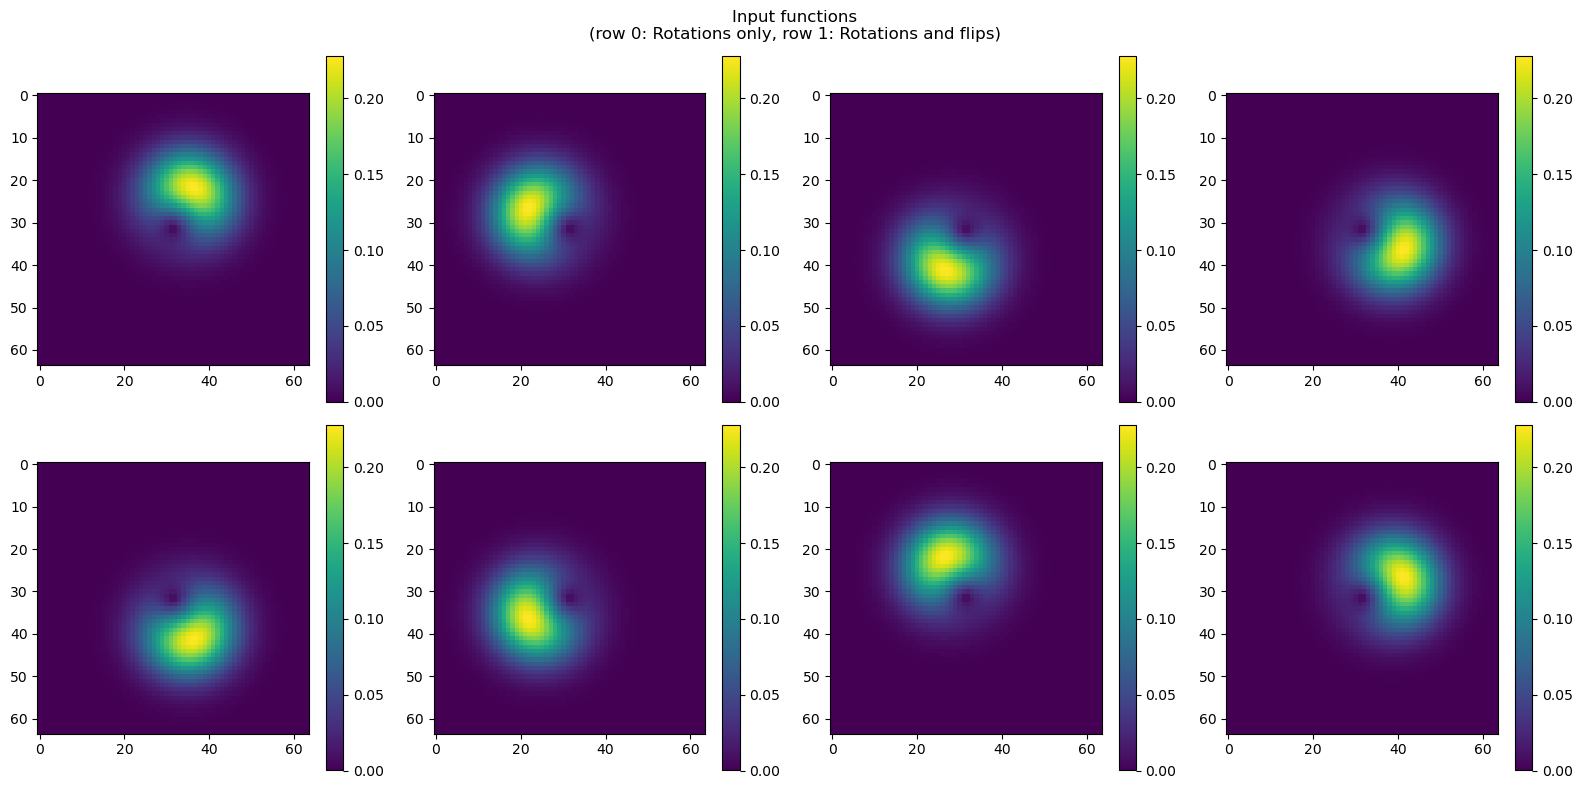

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Input functions\n(row 0: Rotations only, row 1: Rotations and flips)")

for x_idx, (r, c) in enumerate(product(range(2), range(4))):
    fig.colorbar(axes[r, c].imshow(X[x_idx, ..., 0]))
    
fig.tight_layout()
fig.show()

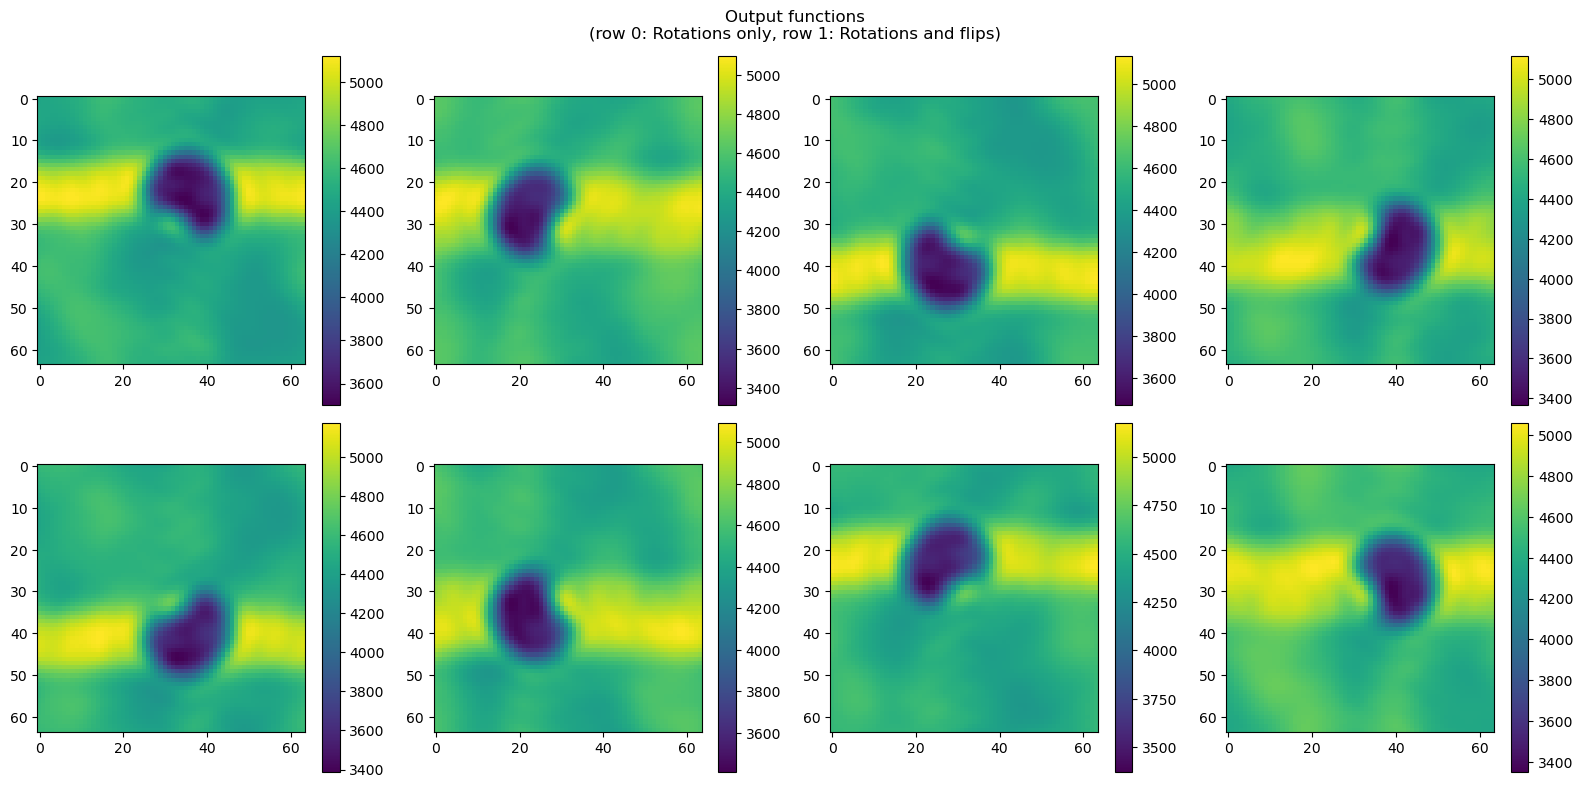

In [4]:
with torch.inference_mode():
    Y = model.forward(X)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Output functions\n(row 0: Rotations only, row 1: Rotations and flips)")

for x_idx, (r, c) in enumerate(product(range(2), range(4))):
    fig.colorbar(axes[r, c].imshow(Y[x_idx, ..., 0]))

fig.tight_layout()
fig.show()

In [5]:
Z = Y[0]
Z = torch.stack(
    [torch.rot90(Z, n, dims=(0,1)) for n in range(4)],
    dim = 0,
)
Z = torch.cat(
    [Z, Z.flip(dims=(1,))],
    dim = 0,
)

In [6]:
max_diff = (Y - Z).norm(p=torch.inf).item()
print(f"Maximum difference: {max_diff:.4e}")

p = 1
rel_error = relative_error(Z, Y, p=p)
print(f"Relative error ({p=}): {rel_error.mean():.4e} +/- {rel_error.std():.4e}")

Maximum difference: 6.4976e+02
Relative error (p=1): 3.3641e-02 +/- 2.1685e-02


In [9]:
%%timeit -n 25 -r 3
with torch.inference_mode():
    Y = model.forward(X)

47.3 ms ± 606 μs per loop (mean ± std. dev. of 3 runs, 25 loops each)


End of file